In [1]:
#Libraries
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel")
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN

include("utils.jl");
include("LoadData.jl");

In [55]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(10);

In [12]:
#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real; #Hidden & Output Weights Scale

#Bayesian Neural Network 

function G2(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

In [56]:
traces = []
folder = "/Data/BostonLong/"
#tests = [1,3,5,6,8,9,10,11,12,13,15,16]
tests = [i for i=1:16]
filename_pre = "trace"
filename_end = "output.jld"

for i=1:16
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

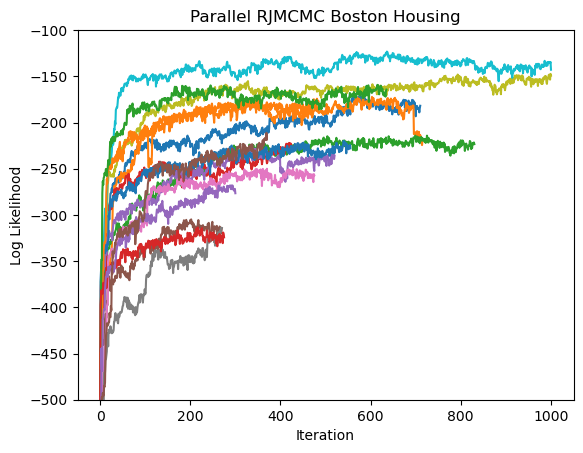

In [57]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores)
end
plt.title("Parallel RJMCMC Boston Housing")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
plt.ylim(-500,-100)

#plt.legend();

In [58]:
for i=1:chains
    println("Chain $i iterations: $(length(traces[i]))")
end

Chain 1 iterations: 711
Chain 2 iterations: 716
Chain 3 iterations: 831
Chain 4 iterations: 426
Chain 5 iterations: 521
Chain 6 iterations: 271
Chain 7 iterations: 476
Chain 8 iterations: 271
Chain 9 iterations: 1001
Chain 10 iterations: 1001
Chain 11 iterations: 556
Chain 12 iterations: 486
Chain 13 iterations: 636
Chain 14 iterations: 276
Chain 15 iterations: 301
Chain 16 iterations: 371


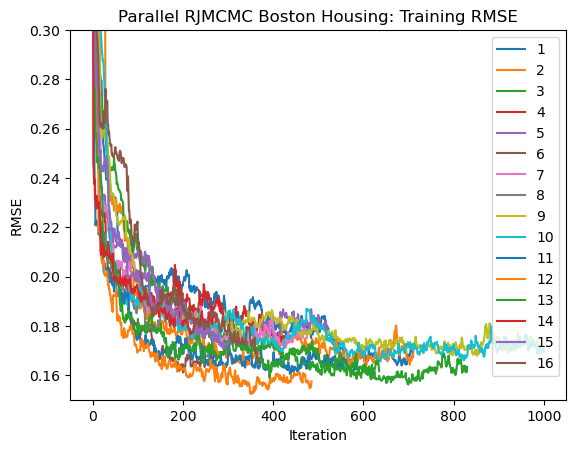

PyObject <matplotlib.legend.Legend object at 0x7f62177c6490>

In [60]:
#Plot Train RMSE for Each Chain

for i=1:16
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_train,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_train)
    end
    plot(rmses, label="$i")
end
plt.title("Parallel RJMCMC Boston Housing: Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.ylim(0.15,0.3)
plt.legend()

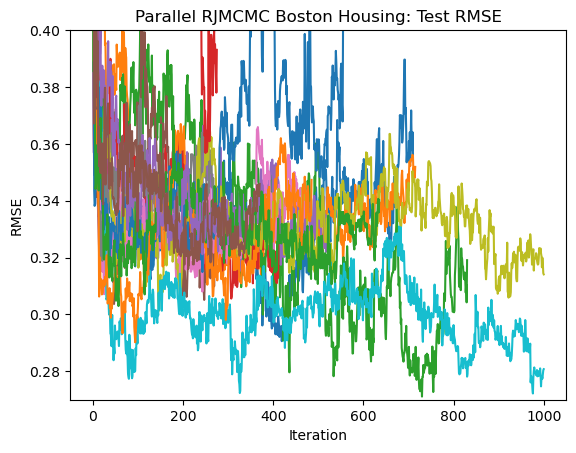

In [61]:
#Plot Test RMSE for Each Chain

for i=1:chains
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_test,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_test)
    end
    plot(rmses)
end
plt.title("Parallel RJMCMC Boston Housing: Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.ylim(0.27,0.4);

In [62]:
#Marginalize RMSE

j = 1

y_marginal = zeros(length(y_train))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for i=j:length(traces2)
        trace = traces2[i]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
        new_mse = mse_scaled(pred_y, y_train)
        total_mse += new_mse
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_train)
println(total_mse / number_traces)

println("Training Set Marginal RMSE: $mse")

y_marginal = zeros(length(y_test))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for i=j:length(traces2)
        trace = traces2[i]
        pred_y = transpose(G(x_test,trace))[:,1]
        new_mse = mse_scaled(pred_y, y_test)
        total_mse += new_mse
        y_marginal += pred_y
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_test)
println(total_mse / number_traces)

println("Test Set Marginal RMSE: $mse")

0.18576535515115375
Training Set Marginal RMSE: 0.15312215375094035
0.33738056648314635
Test Set Marginal RMSE: 0.30844028103965015


In [63]:
#Marginalize all RMSEs

j = 1


for i=1:chains
    traces2 = traces[i]
    y_marginal = zeros(length(y_train))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
    end
    y_marginal = y_marginal ./(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_train)
    println("Chain $i Training Set Marginal RMSE: $mse")
end

for i=1:chains
    traces2 = traces[i]
    y_marginal = zeros(length(y_train))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_test,trace))[:,1]
        y_marginal += pred_y
    end
    y_marginal = y_marginal ./(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_test)
    println("Chain $i Test Set Marginal RMSE: $mse")
end

Chain 1 Training Set Marginal RMSE: 0.16533062189622624
Chain 2 Training Set Marginal RMSE: 0.16427038935305596
Chain 3 Training Set Marginal RMSE: 0.16060351921129756
Chain 4 Training Set Marginal RMSE: 0.17576736376307445
Chain 5 Training Set Marginal RMSE: 0.1728934867271677
Chain 6 Training Set Marginal RMSE: 0.1639643058613201
Chain 7 Training Set Marginal RMSE: 0.17408471312547033
Chain 8 Training Set Marginal RMSE: 0.17076921313060603
Chain 9 Training Set Marginal RMSE: 0.1632039064445836
Chain 10 Training Set Marginal RMSE: 0.16301569722068515
Chain 11 Training Set Marginal RMSE: 0.1577925546277048
Chain 12 Training Set Marginal RMSE: 0.15114502294139892
Chain 13 Training Set Marginal RMSE: 0.157843787715421
Chain 14 Training Set Marginal RMSE: 0.17993497373359185
Chain 15 Training Set Marginal RMSE: 0.1800096222632543
Chain 16 Training Set Marginal RMSE: 0.17767473385320784
Chain 1 Test Set Marginal RMSE: 0.3081910647472156
Chain 2 Test Set Marginal RMSE: 0.3241324810564977
Ch

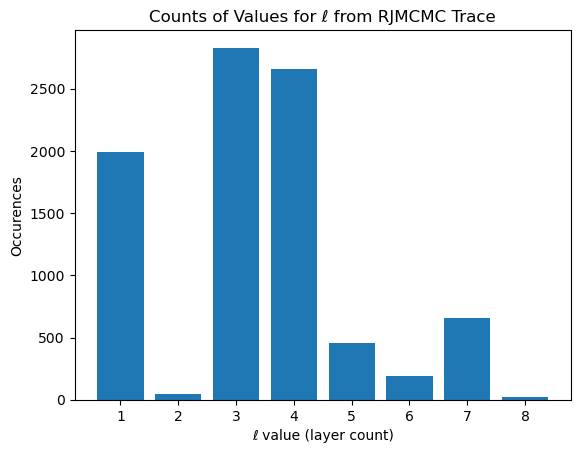

In [64]:
#Bar Plot of l estimates

ls = [[traces[i][j][:l] for j=1:length(traces[i])] for i=1:chains]
ls = collect(Iterators.flatten(ls))

counts = [sum([l_list[ls[i]] == j for i in 1:length(ls)]) for j in l_list]
bar(l_list,counts)

plt.title("Counts of Values for ℓ from RJMCMC Trace")
plt.xlabel("ℓ value (layer count)")
plt.ylabel("Occurences");

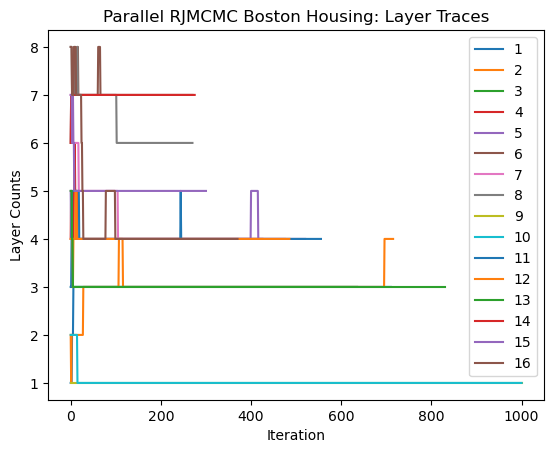

PyObject <matplotlib.legend.Legend object at 0x7f620e1a9510>

In [65]:
#Trace Plot for l
#Plot Train RMSE for Each Chain

for i=1:chains
    chain_ls = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        chain_ls[j] = trace[:l]
    end
    plot(chain_ls, label="$i")
end
plt.title("Parallel RJMCMC Boston Housing: Layer Traces")
plt.xlabel("Iteration")
plt.ylabel("Layer Counts")
plt.legend()

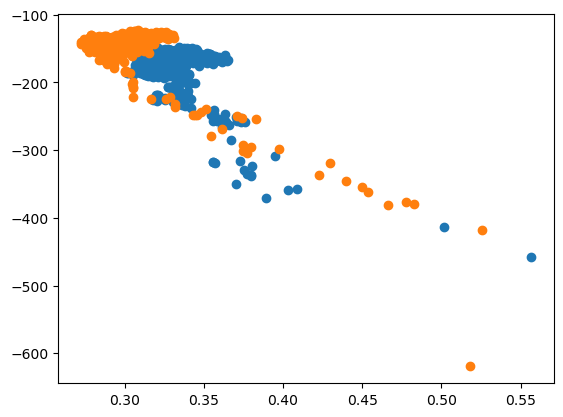

In [67]:
#RMSE Correlation with Log Posterior
for j=9:10
    current_chain = j
    chain_scores = []
    chain_MSES = []
    chain_obs = obs_master
    chain_obs[:y] = y_test
    for i =1:length(traces[current_chain])
        current_trace = traces[current_chain][i]
        push!(chain_scores,get_score(current_trace))
        pred_y = transpose(G(x_test,current_trace))[:,1]
        current_mse = mse_scaled(pred_y, y_test)
        push!(chain_MSES,current_mse)
    end
    scatter(chain_MSES,chain_scores)
    #plot(chain_MSES)
end

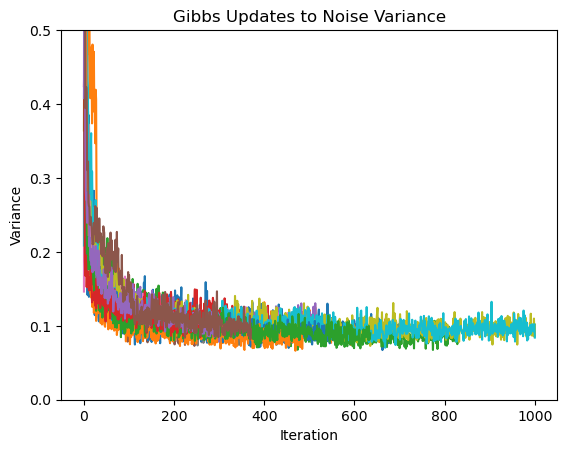

In [68]:
#Plot some hyperparameters
for j=1:16
    chain = j
    taus = [1/traces[chain][i][:τᵧ] for i=1:length(traces[chain])]
    plot(taus)
end
plt.title("Gibbs Updates to Noise Variance")
plt.xlabel("Iteration")
plt.ylabel("Variance")
plt.ylim(0,0.5);